In [1]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\lenovo\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# Create the pypsa network
network = pypsa.Network()

In [3]:
# Define snapshots (time steps)
demand_data = pd.read_csv(r"C:\Users\lenovo\Downloads\Ghana_Hourly_Demand_Profile_2023_Final.csv",index_col=0, parse_dates=True)

In [4]:
demand_data.head()

,Demand (MW)
Timestamp,
2023-01-01 00:00:00,1769.136225
2023-01-01 01:00:00,2596.727941
2023-01-01 02:00:00,2282.567457
2023-01-01 03:00:00,2091.050165
2023-01-01 04:00:00,1455.261412


In [5]:
demand_data["Demand (MW)"]

Timestamp
2023-01-01 00:00:00    1769.136225
2023-01-01 01:00:00    2596.727941
2023-01-01 02:00:00    2282.567457
2023-01-01 03:00:00    2091.050165
2023-01-01 04:00:00    1455.261412
                          ...     
2023-12-31 19:00:00    2458.698586
2023-12-31 20:00:00    1562.235805
2023-12-31 21:00:00    1701.665052
2023-12-31 22:00:00    1532.643989
2023-12-31 23:00:00    1937.672358
Name: Demand (MW), Length: 8760, dtype: float64

In [6]:
network.set_snapshots(demand_data.index)

In [7]:
network.snapshots

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

In [8]:
# add buses
network.add("Bus","electricity")

In [9]:
#Add loads with an hourly demand profile
network.add("Load","demand", bus="electricity", p_set=demand_data["Demand (MW)"])

In [10]:
# t/MWh thermal
emission_factors = dict(
    gas=0.2,
    oil=0.26,
    hydro=0,
    solar=0
)

In [11]:
#Add generators with their profiles
network.add("Generator","gas_plant", bus="electricity",
           p_nom=1887, marginal_cost=50, capital_cost=1200,
            carrier="gas", efficiency=0.55
           )
network.add("Generator","oil_plant", bus="electricity",
           p_nom=1502, marginal_cost=100, capital_cost=1200,
            carrier="oil",efficiency=0.35
           )
network.add("Generator","hydro_plant", bus="electricity",
           p_nom=1580, marginal_cost=0, capital_cost=3000, 
            carrier="hydro",efficiency=0.85
           )
network.add("Generator","solar_plant", bus="electricity",
           p_nom=74, marginal_cost=0, capital_cost=1141.6,
            carrier="solar",efficiency=0.20
           )

In [12]:
network.optimize(solver_name="highs")

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]
INFO:linopy.io: Writing time: 0.43s
INFO:linopy.solvers:Log file at C:\Users\lenovo\AppData\Local\Temp\highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35040 primals, 78840 duals
Objective: 1.54e+08
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


('ok', 'optimal')

In [13]:
network.objective/1e6 #total system costs in million

153.58489311120005

In [14]:
network.generators.p_nom_opt.div(1e3) #GW

Generator
gas_plant      1.887
oil_plant      1.502
hydro_plant    1.580
solar_plant    0.074
Name: p_nom_opt, dtype: float64

In [15]:
network.snapshot_weightings.generators @ network.generators_t.p.div(1e6) #TWh

Generator
gas_plant       3.071698
oil_plant       0.000000
hydro_plant    13.441900
solar_plant     0.486402
Name: generators, dtype: float64

In [16]:
base_results = network.generators_t.p.sum(axis=0)

In [17]:
base_results

Generator
gas_plant      3.071698e+06
oil_plant      0.000000e+00
hydro_plant    1.344190e+07
solar_plant    4.864020e+05
dtype: float64

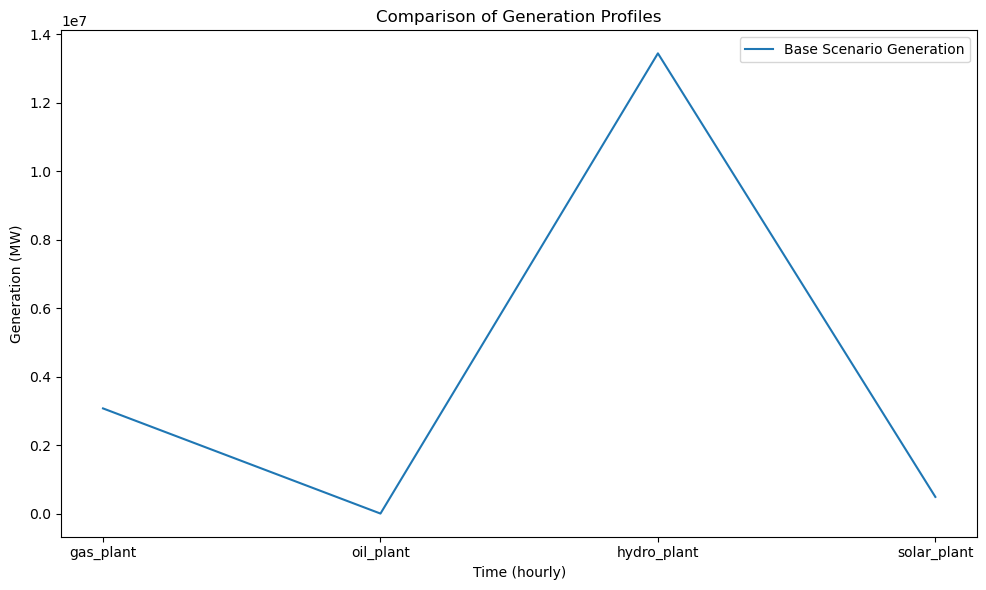

In [18]:
# Compare generation profiles
plt.figure(figsize=(10, 6))
plt.plot(base_results, label="Base Scenario Generation")
plt.title("Comparison of Generation Profiles")
plt.xlabel("Time (hourly)")
plt.ylabel("Generation (MW)")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
#Check if demand was consistently met in all hours using (load data) and  (generation output).
network.loads_t.p 

Load,demand
snapshot,
2023-01-01 00:00:00,1769.136225
2023-01-01 01:00:00,2596.727941
2023-01-01 02:00:00,2282.567457
2023-01-01 03:00:00,2091.050165
2023-01-01 04:00:00,1455.261412
...,...
2023-12-31 19:00:00,2458.698586
2023-12-31 20:00:00,1562.235805
2023-12-31 21:00:00,1701.665052


In [20]:
network.generators_t.p

Generator,gas_plant,oil_plant,hydro_plant,solar_plant
snapshot,,,,
2023-01-01 00:00:00,115.136225,-0.0,1580.000000,74.0
2023-01-01 01:00:00,942.727941,-0.0,1580.000000,74.0
2023-01-01 02:00:00,628.567457,-0.0,1580.000000,74.0
2023-01-01 03:00:00,437.050165,-0.0,1580.000000,74.0
2023-01-01 04:00:00,-0.000000,-0.0,1455.261412,-0.0
...,...,...,...,...
2023-12-31 19:00:00,804.698586,-0.0,1580.000000,74.0
2023-12-31 20:00:00,-0.000000,-0.0,1562.235805,-0.0
2023-12-31 21:00:00,47.665052,-0.0,1580.000000,74.0


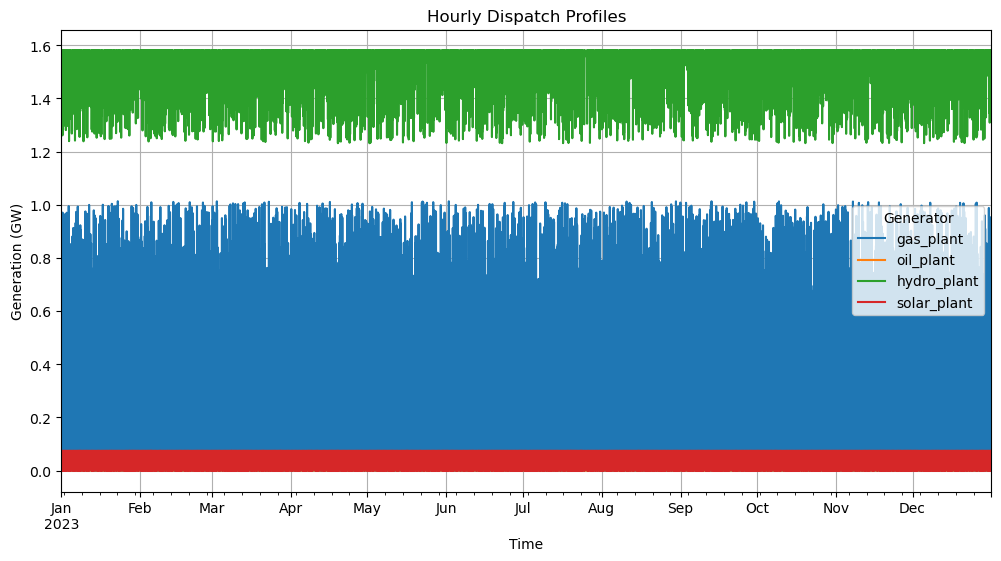

In [21]:
# Plot hourly generation profiles
generation_profiles = network.generators_t.p / 1e3  # Convert MW to GW
generation_profiles.plot(
    figsize=(12, 6),
    title="Hourly Dispatch Profiles",
    xlabel="Time",
    ylabel="Generation (GW)"
)
plt.legend(title="Generator")
plt.grid(True)
plt.show()

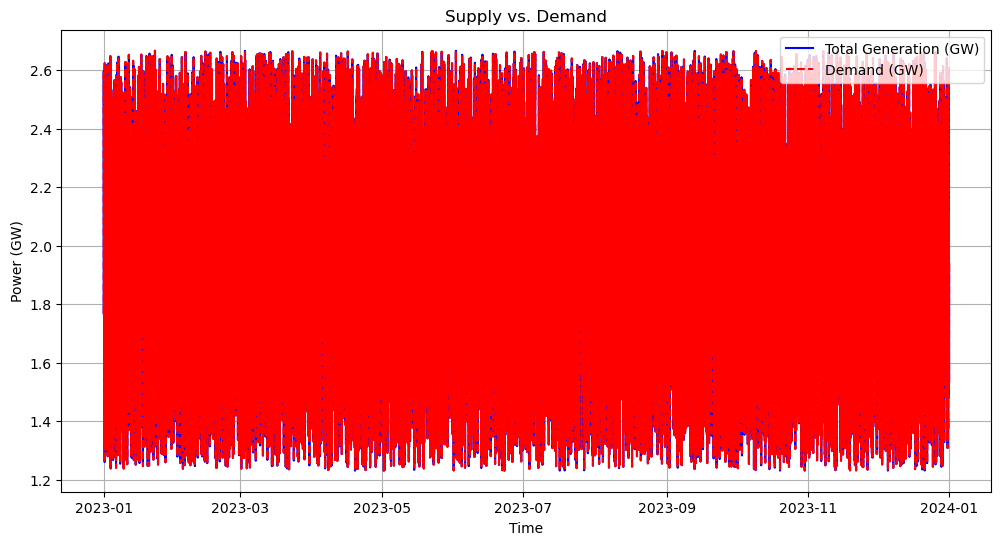

In [22]:
# Calculate total generation and demand
total_generation = generation_profiles.sum(axis=1)  # Sum across generators
demand = network.loads_t.p.sum(axis=1) / 1e3  # Convert MW to GW

# Plot demand vs supply
plt.figure(figsize=(12, 6))
plt.plot(total_generation, label="Total Generation (GW)", color="blue")
plt.plot(demand, label="Demand (GW)", color="red", linestyle="--")
plt.title("Supply vs. Demand")
plt.xlabel("Time")
plt.ylabel("Power (GW)")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Calculate CO2 emissions
emissions = 0
for gen_name, gen in network.generators.iterrows():
    carrier = gen.carrier
    emission_factor = emission_factors[carrier]  # tons of CO2 per MWh
    emissions += (network.generators_t.p[gen_name] * emission_factor).sum()

In [24]:
emissions

614339.5724448

In [25]:
# Convert emissions to kilotons
total_emissions_kt = emissions / 1e3

In [26]:
total_emissions_kt

614.3395724448001